In [57]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE


import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
## set figure size
from pylab import rcParams
rcParams['figure.figsize'] = 12,6

## Business objective

Airline travel insurance become more important as it contribute to additional business profit

Based on customer search behaviour, we will predict whether a customer will buy ancillary (additional product/services). As of now, you have to develop the model for insurance purchase prediction 

## read data

In [3]:
df = pd.read_csv('AncillaryScoring_insurance.csv', encoding ='iso-8859-1')

In [3]:
df.head()

,PAXCOUNT,SALESCHANNEL,TRIPTYPEDESC,PURCHASELEAD,LENGTHOFSTAY,flight_hour,flight_day,ROUTE,geoNetwork_country,BAGGAGE_CATEGORY,SEAT_CATEGORY,FNB_CATEGORY,INS_FLAG,flightDuration_hour
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,0,5.52
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,0,5.52
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,0,5.52
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,0,5.52
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,0,5.52


In [4]:
df.dtypes

PAXCOUNT                 int64
SALESCHANNEL            object
TRIPTYPEDESC            object
PURCHASELEAD             int64
LENGTHOFSTAY             int64
flight_hour              int64
flight_day              object
ROUTE                   object
geoNetwork_country      object
BAGGAGE_CATEGORY         int64
SEAT_CATEGORY            int64
FNB_CATEGORY             int64
INS_FLAG                 int64
flightDuration_hour    float64
dtype: object

## imbalance class handling 

In [76]:
## check target variable class distribution 
df['INS_FLAG'].value_counts()

0    42522
1     7478
Name: INS_FLAG, dtype: int64

- for imbalance dataset, it is normally ratio 9:1 , negative-to-positive class 
- in this dataset, it is around 15% of positive class label, thus no need consider imbalance class handling unless needed later 

## data pre-processing

In [5]:
## detect null & missing value
df.isnull().sum()

PAXCOUNT               0
SALESCHANNEL           0
TRIPTYPEDESC           0
PURCHASELEAD           0
LENGTHOFSTAY           0
flight_hour            0
flight_day             0
ROUTE                  0
geoNetwork_country     0
BAGGAGE_CATEGORY       0
SEAT_CATEGORY          0
FNB_CATEGORY           0
INS_FLAG               0
flightDuration_hour    0
dtype: int64

No missing value in the dataset

## Exploratory data analysis

In [6]:
## summary stats 
df.describe()

,PAXCOUNT,PURCHASELEAD,LENGTHOFSTAY,flight_hour,BAGGAGE_CATEGORY,SEAT_CATEGORY,FNB_CATEGORY,INS_FLAG,flightDuration_hour
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,0.149560,7.277561
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,0.356643,1.496863
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,4.670000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,0.000000,5.620000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,0.000000,7.570000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,0.000000,8.830000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,1.000000,9.500000


&lt;matplotlib.axes._subplots.AxesSubplot at 0x22e24f2aa08&gt;

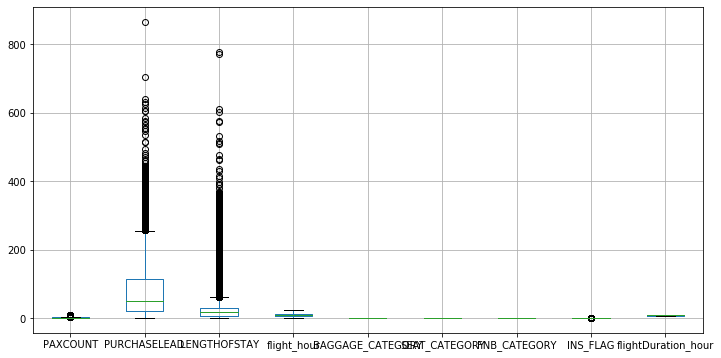

In [57]:
## boxplot 
df.boxplot()

the boxsplot show "purchaseLead" and "lengthOfStay" has outlier that outside Q3 upper quadrile range

In [29]:
## top n items with highest occurance   
df['ROUTE'].value_counts().nlargest(10)

AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
ICNSYD     695
DMKPER     679
DPSICN     666
DMKOOL     655
MELPEN     649
Name: ROUTE, dtype: int64

In [42]:
## top distinct count of items 
df['ROUTE'].value_counts().nunique()


799

In [63]:
df['TRIPTYPEDESC'].value_counts().nlargest(10) 

RoundTrip     49497
OneWay          387
CircleTrip      116
Name: TRIPTYPEDESC, dtype: int64

In [30]:
## top n items with highest occurance
df['SALESCHANNEL'].value_counts().nlargest(10)


Internet    44382
Mobile       5618
Name: SALESCHANNEL, dtype: int64

In [66]:
print( df['geoNetwork_country'].value_counts().nlargest(10)
)
print( 'distinct count:' , df['ROUTE'].value_counts().nunique())

Australia      17872
Malaysia        7174
South Korea     4559
Japan           3885
China           3387
Indonesia       2369
Taiwan          2077
Thailand        2030
India           1270
New Zealand     1074
Name: geoNetwork_country, dtype: int64
distinct count: 197


                     PAXCOUNT  PURCHASELEAD  LENGTHOFSTAY  flight_hour  \
PAXCOUNT             1.000000      0.212606     -0.115850     0.015607   
PURCHASELEAD         0.212606      1.000000     -0.076560     0.035973   
LENGTHOFSTAY        -0.115850     -0.076560      1.000000    -0.024872   
flight_hour          0.015607      0.035973     -0.024872     1.000000   
BAGGAGE_CATEGORY     0.120404     -0.022207      0.176757    -0.011434   
SEAT_CATEGORY        0.028544     -0.004499      0.032264     0.012171   
FNB_CATEGORY         0.022943     -0.022653      0.098828     0.013014   
INS_FLAG             0.024116     -0.022131     -0.042408     0.007127   
flightDuration_hour -0.063169      0.067866      0.141181    -0.002101   

                     BAGGAGE_CATEGORY  SEAT_CATEGORY  FNB_CATEGORY  INS_FLAG  \
PAXCOUNT                     0.120404       0.028544      0.022943  0.024116   
PURCHASELEAD                -0.022207      -0.004499     -0.022653 -0.022131   
LENGTHOFSTAY       

&lt;matplotlib.axes._subplots.AxesSubplot at 0x22e24ce1a88&gt;

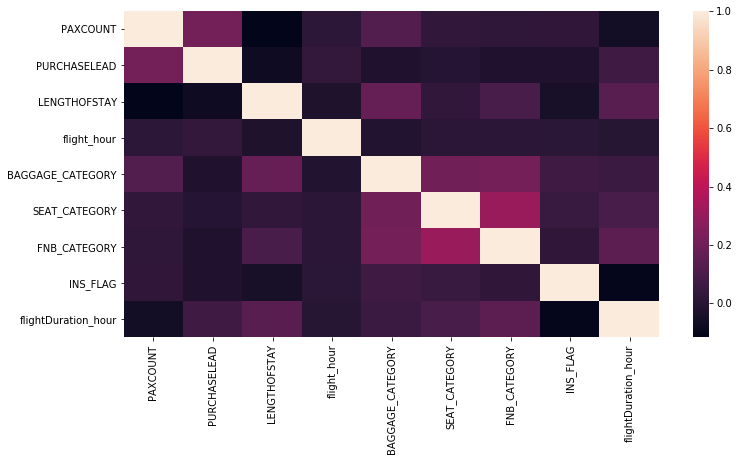

In [58]:
## correlation 


# calculate the correlation matrix
corr = df.corr()

print(corr)

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)



- Most of the variables show low correlation with each other
- INS_FLAG doesn't show any high correlation with other variable
- correlation not nessary causation, further analysis and feature selection needed 

### Data visualization & histogram plot

In [36]:
# 	from pandas.plotting import scatter_matrix
# scatter_matrix(df[:100], alpha=0.2, figsize=(6, 6), diagonal='kde')

[&#39;PAXCOUNT&#39;, &#39;PURCHASELEAD&#39;, &#39;LENGTHOFSTAY&#39;, &#39;flight_hour&#39;, &#39;BAGGAGE_CATEGORY&#39;, &#39;SEAT_CATEGORY&#39;, &#39;FNB_CATEGORY&#39;, &#39;INS_FLAG&#39;, &#39;flightDuration_hour&#39;]


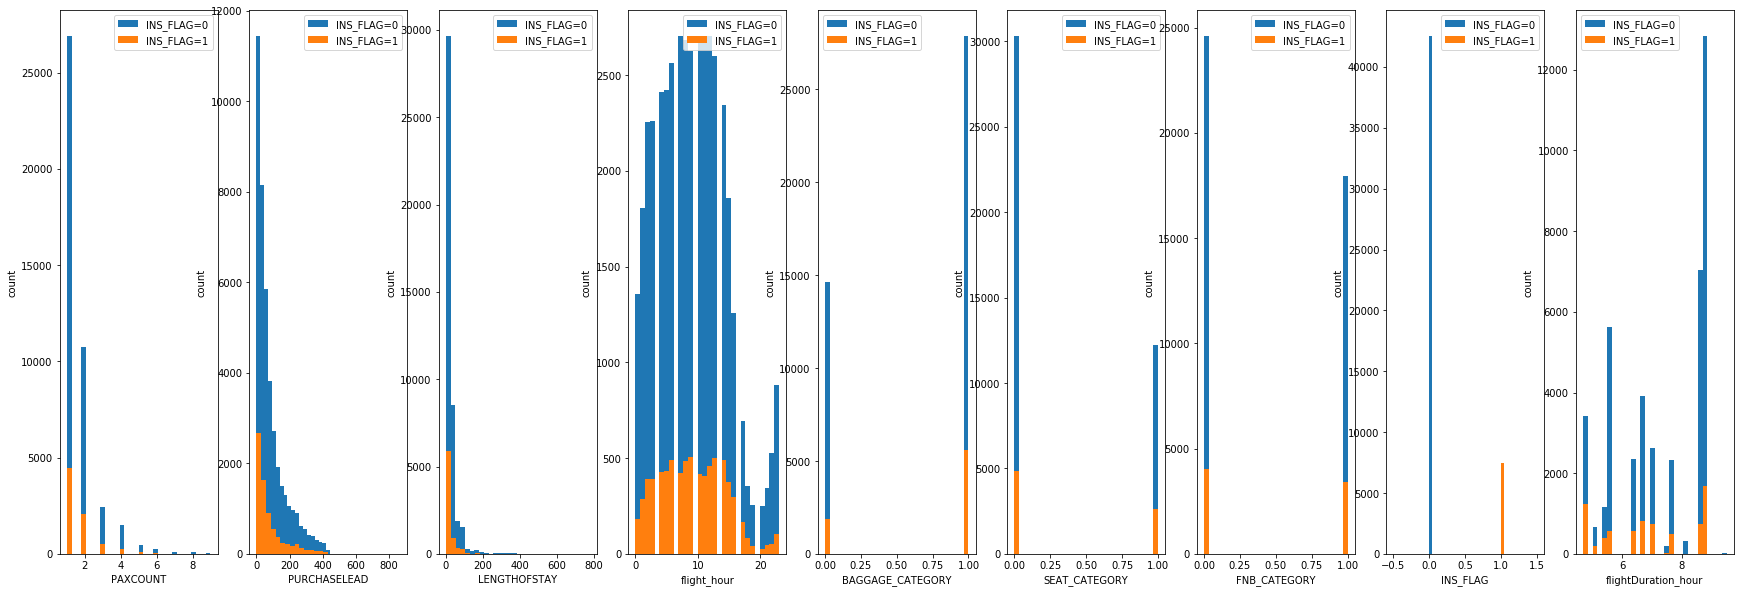

In [11]:
## select columns that is numeric and continuous 
continues_var=[i for i in df.columns if df[i].dtypes !='object']

print(continues_var)

fig , ax = plt.subplots(1,9,figsize=(30,10))

for i , x in enumerate(continues_var):
    ax[i].hist( df[x][df.INS_FLAG== 0 ],label='INS_FLAG=0',bins=30)
    ax[i].hist( df[x][df.INS_FLAG== 1],label='INS_FLAG=1',bins=30)
    ax[i].set(xlabel=x,ylabel='count')
    ax[i].legend()

Based on the distribution above "INS_FLAG vs Variables 'PAXCOUNT', 'PURCHASELEAD', 'LENGTHOFSTAY', 'flight_hour', 'BAGGAGE_CATEGORY', 'SEAT_CATEGORY', 'FNB_CATEGORY', 'INS_FLAG', 'flightDuration_hour' "

there are no obvious  difference in distribution between those had purchased insurance & those doesn't 

In [37]:
# df.ROUTE.value_counts().plot(kind='bar');


## handling categorical data & create label data for training  (e.g. label encoding or one-hot-encoding)


ROUTE, geoNetwork_country,flight_day,TRIPTYPEDESC,SALESCHANNEL --> we need convert into numeric class using label encoder (NOTE: Tree-based model is able handle the numeric class, thus not require one-hot-encoding which will create sparse matrix and runtime inefficiency)

'SALESCHANNEL' 'BAGGAGE_CATEGORY','SEAT_CATEGORY','FNB_CATEGORY' is a binary class, thus we can remain existing value and no need label-encoder or one-hot-encoding

In [4]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in new label column
df['ROUTE_code'] = labelencoder.fit_transform(df['ROUTE'])
df['geoNetwork_country_code'] = labelencoder.fit_transform(df['geoNetwork_country'])
df['flight_day_code'] = labelencoder.fit_transform(df['flight_day'])
df['TRIPTYPEDESC_code'] = labelencoder.fit_transform(df['TRIPTYPEDESC'])
df['SALESCHANNEL_code'] = labelencoder.fit_transform(df['SALESCHANNEL'])

df.head(20)


,PAXCOUNT,SALESCHANNEL,TRIPTYPEDESC,PURCHASELEAD,LENGTHOFSTAY,flight_hour,flight_day,ROUTE,geoNetwork_country,BAGGAGE_CATEGORY,SEAT_CATEGORY,FNB_CATEGORY,INS_FLAG,flightDuration_hour,ROUTE_code,geoNetwork_country_code,flight_day_code,TRIPTYPEDESC_code,SALESCHANNEL_code
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,0,5.52,0,61,2,2,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,0,5.52,0,61,2,2,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,0,5.52,0,36,6,2,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,0,5.52,0,61,2,2,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,0,5.52,0,36,6,2,0
5,1,Internet,RoundTrip,3,48,20,Thu,AKLDEL,New Zealand,1,0,1,0,5.52,0,61,4,2,0
6,3,Internet,RoundTrip,201,33,6,Thu,AKLDEL,New Zealand,1,0,1,0,5.52,0,61,4,2,0
7,2,Internet,RoundTrip,238,19,14,Mon,AKLDEL,India,1,0,1,0,5.52,0,36,1,2,0
8,1,Internet,RoundTrip,80,22,4,Mon,AKLDEL,New Zealand,0,0,1,0,5.52,0,61,1,2,0
9,1,Mobile,RoundTrip,378,30,12,Sun,AKLDEL,India,0,0,0,0,5.52,0,36,3,2,1


## train test data 

In [25]:

# prepare train and test data for model training

X = df.drop(columns=['INS_FLAG','ROUTE', 'geoNetwork_country','flight_day','TRIPTYPEDESC','SALESCHANNEL'])
y = df['INS_FLAG']

## train test split size, random seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Model 1 (baseline) - XGBoost Classifier 

In [6]:
import xgboost as xgb
from sklearn.metrics import explained_variance_score


xgr = XGBClassifier( n_estimators= 3000, max_depth=7)


## fit the model to train data set
xgr.fit(X_train, y_train , eval_metric= 'auc', verbose = 200)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type=&#39;gain&#39;, interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=3000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [7]:
predictions = xgr.predict(X_test)
predictions

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [11]:
## overall model accucary
from sklearn import metrics

predictions = xgr.predict(X_test)


print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))


print(confusion_matrix(y_test, predictions) )  
print(classification_report(y_test, predictions) ) 

Accuracy: 0.8352
Precision: 0.40948275862068967
Recall: 0.25675675675675674
[[7972  548]
 [1100  380]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      8520
           1       0.41      0.26      0.32      1480

    accuracy                           0.84     10000
   macro avg       0.64      0.60      0.61     10000
weighted avg       0.81      0.84      0.82     10000



[[7972  548]
 [1100  380]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      8520
           1       0.41      0.26      0.32      1480

    accuracy                           0.84     10000
   macro avg       0.64      0.60      0.61     10000
weighted avg       0.81      0.84      0.82     10000



- Based on Xgboost  Classifer result above, we able to get average 84% accuracy
- however in order to measure the robustness of classifier with potential imbalance data set (15% minority class, class-1), we need to consider the f1-score ((harmonic mean of precision and recall))  for both class classify class-1 (those who bought insurance)  , which is f1-score =0.32  )
- this may caused by imbalance class input data (15% positive class data)
- we will apply SMOTE sampling to check for improvement
- or feature engineering & parameter tuning needed for improvement


## Feature importance plot 

&lt;matplotlib.axes._subplots.AxesSubplot at 0x22e2fbbed48&gt;

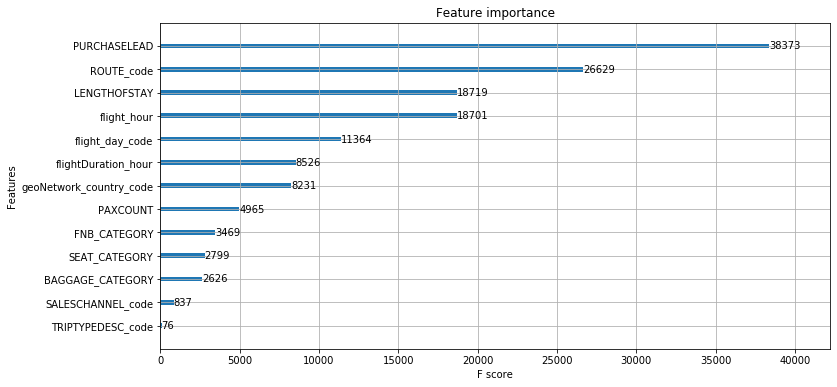

In [81]:
xgb.plot_importance( xgr)


the feature importance plot show the top 5 contributing factor 
- purchase lead amount
- route
- lenght of stay
- flight hour
- flight day code

the least contributing factor
- trip type (round trip, one-way , cycle)
- sales channel (mobile, desktop)
- baggage category

## Model 1.2 Xgboost - SMOTE oversampling on training data (treat imbalance class)

^C


In [31]:
## transform the dataset
from imblearn.over_sampling import RandomOverSampler


## apply overampling to training dataset

oversample = SMOTE()
# oversample = RandomOverSampler(sampling_strategy='minority')
X_train_os, y_train_os = oversample.fit_resample( X_train, y_train)

## xgbclassifier params
xgr = XGBClassifier( n_estimators= 3000, max_depth=7)


## fit the model to train data set (using oversampling data)
xgr.fit(X_train_os, y_train_os , eval_metric= 'auc', verbose = 200)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type=&#39;gain&#39;, interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=3000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [32]:
X_train_os.shape, X_train.shape

((68004, 13), (40000, 13))

In [33]:
predictions = xgr.predict(X_test)


print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))


print(confusion_matrix(y_test, predictions) )  
print(classification_report(y_test, predictions) ) 

Accuracy: 0.8116
Precision: 0.35255474452554747
Recall: 0.32635135135135135
[[7633  887]
 [ 997  483]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      8520
           1       0.35      0.33      0.34      1480

    accuracy                           0.81     10000
   macro avg       0.62      0.61      0.61     10000
weighted avg       0.81      0.81      0.81     10000



- after apply SMOTE oversample to training data, the classifier f1-score improve to 0.34 . however the accuracy decline abit to 81% 

## Model 1.3 - Xgboost cross-validation using random search on best params

In [82]:
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# CV model
model = xgboost.XGBClassifier()
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, y, cv=kfold)

print("Accuracy: %.2f%% ( std = %.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 84.89% ( std = 4.98%)


In [80]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        # 'eta':[0.1,0.15,0.2],
        'n_estimators': [2000,3000,5000],
        # 'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7]
        }

## cross validation on best parameter
folds = 5
param_combination = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV( xgr, param_distributions=params, n_iter=param_combination, scoring='roc_auc', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001 )

## random search on best parameter
random_search.fit(X, y)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 11.1min finished


RandomizedSearchCV(cv=&lt;generator object _BaseKFold.split at 0x0000022453389348&gt;,
                   estimator=XGBClassifier(base_score=0.5, booster=None,
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.6, gamma=0,
                                           gpu_id=-1, importance_type=&#39;gain&#39;,
                                           interaction_constraints=None,
                                           learning_rate=0.2, max_delta_step=0,
                                           max_depth=7, min_child_weight=5,
                                           missing=nan,
                                           monotone_const...
                                           num_parallel_tree=1, random_state=0,
                                           reg_alpha=0, reg_lambda=1,
                                           scale_pos_weig

In [81]:
## show model best parameter
print(random_search.best_params_)


{&#39;subsample&#39;: 0.6, &#39;n_estimators&#39;: 3000, &#39;min_child_weight&#39;: 5, &#39;max_depth&#39;: 3, &#39;colsample_bytree&#39;: 1.0}


In [82]:

## xgbclassifier params (using best params from random search)
xgr = XGBClassifier( n_estimators= 3000, max_depth=3, min_child_weight=5 , colsample_bytree=1 , subsample=1 )


## fit the model to train data set (using oversampling data)
xgr.fit(X_train_os, y_train_os , eval_metric= 'auc', verbose = 200)

predictions = xgr.predict(X_test)


print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))


print(confusion_matrix(y_test, predictions) )  
print(classification_report(y_test, predictions) ) 

Accuracy: 0.7974
Precision: 0.3468013468013468
Recall: 0.4175675675675676
[[7356 1164]
 [ 862  618]]
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      8520
           1       0.35      0.42      0.38      1480

    accuracy                           0.80     10000
   macro avg       0.62      0.64      0.63     10000
weighted avg       0.81      0.80      0.80     10000



- with the 5-fold grid search with 5-parameter combination, we able find the best parameter and improve the overall f1-score on class 1

In [83]:
import joblib

# save the model to file
filename = 'xgboost_gs.sav'
joblib.dump( xgr, filename)

[&#39;xgboost_gs.sav&#39;]

&lt;matplotlib.axes._subplots.AxesSubplot at 0x2245cb9f9c8&gt;

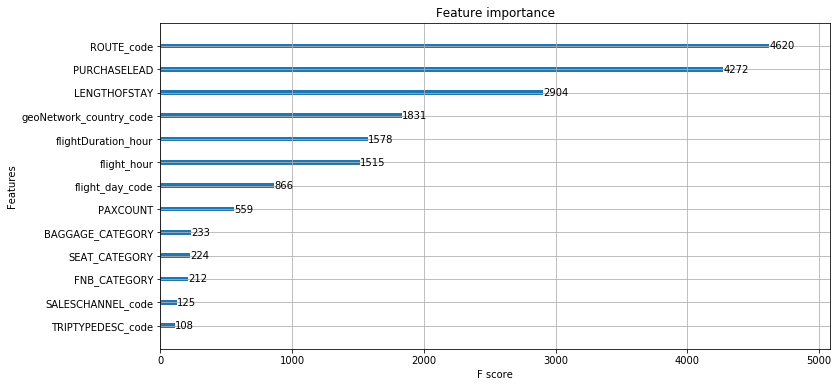

In [84]:
xgb.plot_importance( xgr)


after tuning xgboost with best parameter, there are slightly change in the top 5 important features:
- route (from 2nd to 1st place)
- purchase lead amount (from 1st to 2nd)
- lenght of stay
- geonetwork country (new added to top 5)
- flight duration
- flight hour

the least contributing factor still remain the same
- trip type (round trip, one-way , cycle)
- sales channel (mobile, desktop)
- baggage category

## Model 2 - Random forest classifier

In [90]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, n_estimators=3000, class_weight='balanced')

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=&#39;balanced&#39;,
                       criterion=&#39;gini&#39;, max_depth=None, max_features=&#39;auto&#39;,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [91]:
predictions = rfc.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))

Accuracy: 0.8568
Precision: 0.6008403361344538
Recall: 0.09662162162162162


In [92]:
from sklearn.metrics import classification_report, confusion_matrix  

print(confusion_matrix(y_test, predictions) )  
print(classification_report(y_test, predictions) ) 

[[8425   95]
 [1337  143]]
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.60      0.10      0.17      1480

    accuracy                           0.86     10000
   macro avg       0.73      0.54      0.54     10000
weighted avg       0.82      0.86      0.81     10000



- Based on RandomForest classification result above, we able to get average 86% accuracy
- however this is not a robust classifier, as it failed to detect & classify class-1 (those who bought insurance) accurately , f1-score =0.17 only
- this may caused by imbalance class input data
- feature engineering & parameter tuning needed for improvement


## Model 3 - Naive bayes classifier

In [93]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model_NB = GaussianNB()

model_NB.fit(X_train, y_train)


GaussianNB(priors=None, var_smoothing=1e-09)

In [94]:
predictions = model_NB.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))

Accuracy: 0.8224
Precision: 0.24305555555555555
Recall: 0.0945945945945946


In [95]:
from sklearn.metrics import classification_report, confusion_matrix  

print(confusion_matrix(y_test, predictions) )  
print(classification_report(y_test, predictions) ) 

[[8084  436]
 [1340  140]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      8520
           1       0.24      0.09      0.14      1480

    accuracy                           0.82     10000
   macro avg       0.55      0.52      0.52     10000
weighted avg       0.77      0.82      0.79     10000



- Based on Naive Bayes classification result above, we able to get average 82% accuracy
- however this is not a robust classifier, as it failed to detect & classify class-1 (those who bought insurance) accurately , f1-score =0.14 only
- this may caused by imbalance class input data
- feature engineering & parameter tuning needed for improvement


## Finding & next action

## (1) Model evaluation
Total we have 3 classifiers (all accuracy >80%)
- Model 1 - XGboostClassifier (f1 = 0.32)
- Model 1.2 Xgboost + SMOTE oversampling (f1 = 0.34)
- Model 1.3 Xgboost + SMOTE oversampling + gridsearch (f1 = 0.38)
- Model 2 - RandomForestClassifier (f1 = 0.17)
- Model 3 - NaiveBayesClassifier (f1 = 0.14)

All 3 achieve overall accuracy achieve accuracy >80%, with Model-1.3 Xgbosst classifier + oversample + gridsearch outperform other  with f1-score (class-1)=0.38


## (2) Feature importance 
after tuning xgboost with best parameter, there are slightly change in the top 5 important features:
- route (from 2nd to 1st place)
- purchase lead amount (from 1st to 2nd)
- lenght of stay
- geonetwork country (new added to top 5)
- flight duration
- flight hour

the least contributing factor still remain the same
- trip type (round trip, one-way , cycle)
- sales channel (mobile, desktop)
- baggage category



## (3)Future action and improvement:
- feature engineering with expert-judgement to select the optimized list of features
- add in user demographic data (age,gender,race, income-level & other) 
- add in time-series transaction data feature (to show the trend, seasonality & noise effect)
- consolidate geo-location data (geonetwork-country) & route (origin - destination pair)
- Normalize the numeric data (e.g. saleslead amount , flightHour) --  makes training less sensitive to the scale of features, so we can better solve for coefficients.


